In [1]:
from utils import *
from scipy import optimize

## 2D Function

### Dataset

In [2]:
z = np.linspace(-2, 2, 100)
x = (z**2 + 1) * np.sin(np.linspace(-np.pi, np.pi, 100))
y = (z**2 + 1) * np.cos(np.linspace(-np.pi, np.pi, 100))

X = np.stack((x, y), axis=1)
z = z.reshape((-1, 1))
X_norm = normalize(X)

In [3]:
X_train, X_test, z_train, z_test = train_test_split(
    X, z, test_size=0.5, random_state=624562)

### Gaussian Process - Noiseless

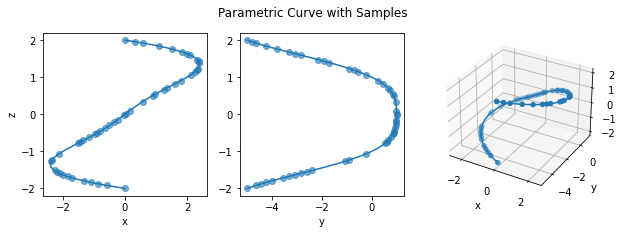

In [4]:
_ = plot((X, X_train), (z.ravel(), z_train), typ='data', title="Parametric Curve with Samples")

In [5]:
X_train_norm = normalize(X_train)
z_train_norm = normalize(z_train)

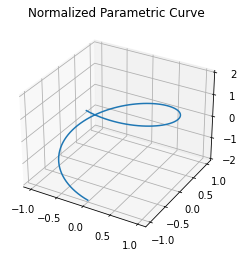

In [6]:
fig = plt.figure(); ax = fig.add_subplot(projection='3d')
ax.plot(X_norm[:,0], X_norm[:,1], z.ravel())
_=ax.set_title("Normalized Parametric Curve")

In [7]:
def g(ell, gp, residual):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})

    gp.fit(X_train_norm, z_train)
    mean = gp.predict(normalize(X_test))

    return -np.corrcoef((residual)[:, 0], (z_test-mean)[:, 0])[0, 1]

In [8]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2, bias=1e-9, 
        bias_bounds=(1e-9, 1e2)) #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_ntk = GPR(kernel=neural_tangent_kernel, normalize_y=True, alpha=1e-5, n_restarts_optimizer=9, random_state=3480795)
gp_ntk.fit(X_train_norm, z_train)
mean_ntk = gp_ntk.predict(normalize(X_test))

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    Matern(length_scale=1,
        length_scale_bounds='fixed',#(1e-9, 1e3), 
        nu=1/2) #+
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)


gp_lpk = GPR(kernel=laplace_kernel, alpha=1e-5, normalize_y=True, n_restarts_optimizer=9, random_state=3480795)
ell_lpk = optimize.minimize_scalar(g, args=(gp_lpk, z_test-mean_ntk), method='bounded', bounds=[0.0001, 100], options={'maxiter': 10000})
gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
gp_lpk.fit(X_train_norm, z_train)
mean_lpk_opt = gp_lpk.predict(normalize(X_test))

print('NTK     : ', gp_ntk.kernel_)
print('Laplace : ', gp_lpk.kernel_)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  1.27**2 * NTK(depth=2, c=2.000, bias=0.685)
Laplace :  2.32**2 * Matern(length_scale=9.53, nu=0.5)


In [9]:
mean_ntk = gp_ntk.predict(X_norm)
mean_lpk = gp_lpk.predict(X_norm)

(<Figure size 720x216 with 3 Axes>,
 array([<AxesSubplot:xlabel='x', ylabel='Posterior vals'>,
        <AxesSubplot:xlabel='y'>, <Axes3DSubplot:xlabel='x', ylabel='y'>],
       dtype=object))

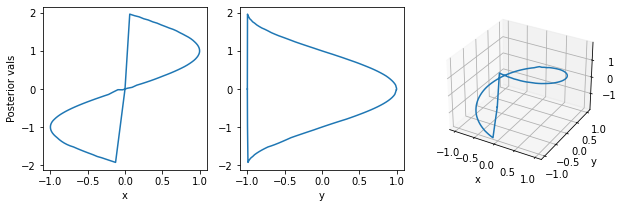

In [10]:
plot(X_norm, mean_ntk.ravel(), 'kernel')

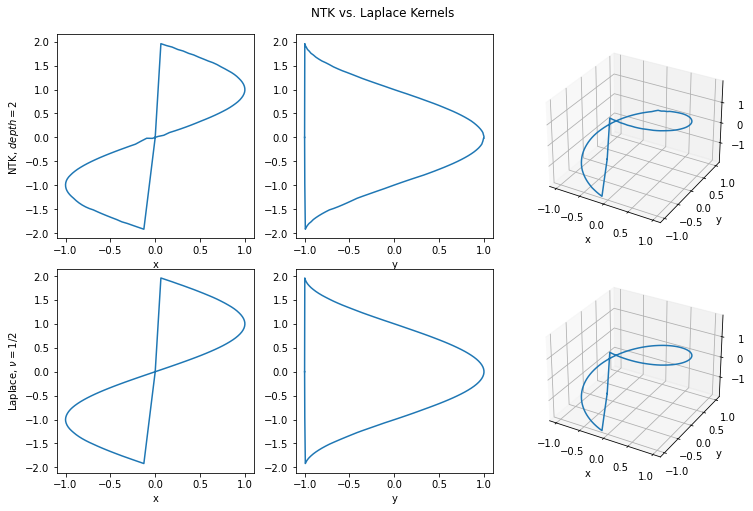

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=False, figsize=(10, 7), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax = ax.ravel()
ax[2].remove()
ax[2] = fig.add_subplot(2,3,3, projection='3d')
ax[5].remove()
ax[5] = fig.add_subplot(2,3,6, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(X_norm[:,0], mean_ntk.ravel())
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'NTK, $depth=2$')
ax[1].plot(X_norm[:,1], mean_ntk.ravel())
ax[1].set_xlabel('y')
ax[2].plot(X_norm[:,0], X_norm[:,1], mean_ntk.ravel())
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')

ax[3].plot(X_norm[:,0], mean_lpk.ravel())
ax[3].set_xlabel('x')
ax[3].set_ylabel(r'Laplace, $\nu = 1/2$')
ax[4].plot(X_norm[:,1], mean_lpk.ravel())
ax[4].set_xlabel('y')
ax[5].plot(X_norm[:,0], X_norm[:,1], mean_lpk.ravel())
ax[5].set_xlabel('x')
ax[5].set_ylabel('y')

_=fig.suptitle("NTK vs. Laplace Kernels")

### Gaussian Process - Noisy

In [12]:
X_train_noisy = np.random.normal(X_train, scale=0.15)
z_train_noisy = np.random.normal(z_train, scale=0.15)

X_noisy = np.random.normal(X, scale=0.15)
# X_noisy = X

In [13]:
X_train_noisy_norm = normalize(X_train_noisy)
z_train_noisy_norm = normalize(z_train_noisy)

X_noisy_norm = normalize(X_noisy)

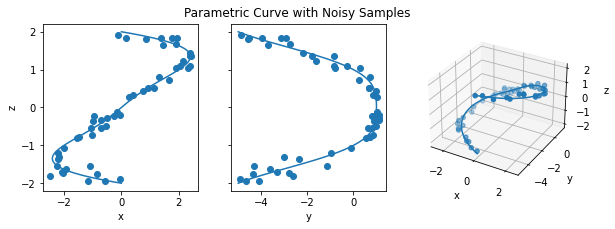

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True ,figsize=(8, 3), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax3.remove()
ax3 = fig.add_subplot(1,3,3, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.9)

ax1.plot(X[:,0], z)
ax1.scatter(X_train_noisy[:,0], z_train_noisy)
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax2.plot(X[:,1], z)
ax2.scatter(X_train_noisy[:,1], z_train_noisy)
ax2.set_xlabel('y')
ax3.plot(X[:,0], X[:,1], z.ravel())
ax3.scatter(X_train_noisy[:,0], X_train_noisy[:,1], z_train_noisy)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
_ = fig.suptitle("Parametric Curve with Noisy Samples")

In [15]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2, bias=1e-9, bias_bounds=(1e-9, 1e2)) + 
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_ntk_noisy = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk_noisy.fit(X_train_noisy_norm, z_train_noisy_norm)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e10)) * 
    Matern(length_scale_bounds=(2e-10, 1e5), nu=1/2) +
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk_noisy = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk_noisy.fit(X_train_noisy_norm, z_train_noisy_norm)

print('NTK     : ', gp_ntk_noisy.kernel_, '\nLaplace : ', gp_lpk_noisy.kernel_)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NTK     :  1.1**2 * NTK(depth=2, c=2.000, bias=32.226) + WhiteKernel(noise_level=0.093) 
Laplace :  1.19**2 * Matern(length_scale=3.62, nu=0.5) + WhiteKernel(noise_level=0.0952)


In [16]:
# Predict on noisy dataset
mean_ntk_noisy = gp_ntk_noisy.predict(X_noisy_norm)
mean_lpk_noisy = gp_lpk_noisy.predict(X_noisy_norm)

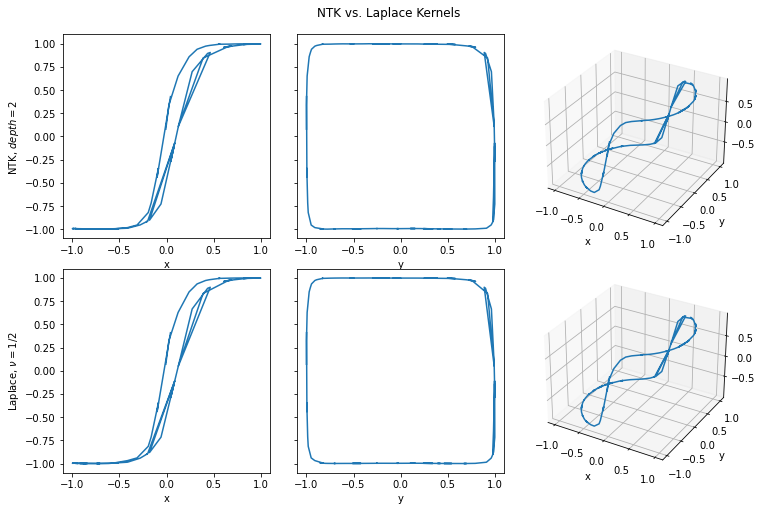

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True ,figsize=(10, 7), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax = ax.ravel()
ax[2].remove()
ax[2] = fig.add_subplot(2,3,3, projection='3d')
ax[5].remove()
ax[5] = fig.add_subplot(2,3,6, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(X_noisy_norm[:,0], mean_ntk_noisy.ravel())
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'NTK, $depth=2$')
ax[1].plot(X_noisy_norm[:,1], mean_ntk_noisy.ravel())
ax[1].set_xlabel('y')
ax[2].plot(X_noisy_norm[:,0], X_noisy_norm[:,1], mean_ntk_noisy.ravel())
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')

ax[3].plot(X_noisy_norm[:,0], mean_lpk_noisy.ravel())
ax[3].set_xlabel('x')
ax[3].set_ylabel(r'Laplace, $\nu = 1/2$')
ax[4].plot(X_noisy_norm[:,1], mean_lpk_noisy.ravel())
ax[4].set_xlabel('y')
ax[5].plot(X_noisy_norm[:,0], X_noisy_norm[:,1], mean_lpk_noisy.ravel())
ax[5].set_xlabel('x')
ax[5].set_ylabel('y')

_=fig.suptitle("NTK vs. Laplace Kernels")

### Sample Paths

(<Figure size 720x216 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <Axes3DSubplot:>], dtype=object))

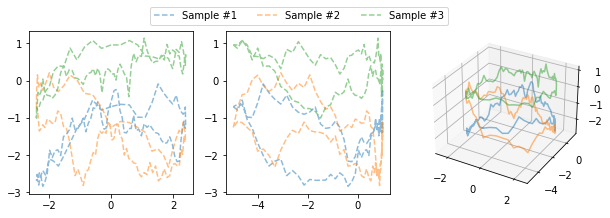

In [18]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e2)) * 
    NTK(depth=3, c=2, bias=100, bias_bounds='fixed') #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

laplace_kernel = (
    ConstantKernel(constant_value=1e-2, constant_value_bounds=(1e-9, 1e2)) * 
    Matern(length_scale=1, 
        length_scale_bounds='fixed',#(2e-10, 1e5), 
        nu=1/2) #+
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

gp_ntk_sample = GPR(kernel=neural_tangent_kernel)
mean_ntk_sample = gp_ntk_sample.predict(X_norm)
samples_ntk = gp_ntk_sample.sample_y(X_norm, 3)

gp_lpk_sample = GPR(kernel=laplace_kernel)
mean_lpk_sample = gp_lpk_sample.predict(X_norm)
samples_lpk = gp_lpk.sample_y(X_norm, 3)
samples_lpk = np.squeeze(samples_lpk)

plot(X, samples_ntk.T, 'sample')

# fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
# ax = ax.ravel()
# ax[2].remove()
# ax[2] = fig.add_subplot(2,3,3, projection='3d')
# ax[5].remove()
# ax[5] = fig.add_subplot(2,3,6, projection='3d')
# fig.tight_layout()
# fig.subplots_adjust(top=.9)

# for i, prior in enumerate(samples_ntk.T):
#     ax[0].plot(X_norm[:,0], prior, linestyle="--", alpha=0.5, label=f"Sampled function #{i + 1}")
#     ax[1].plot(X_norm[:,1], prior, linestyle="--", alpha=0.5)
#     ax[2].plot(X_norm[:,0], X_norm[:,1], prior, alpha=0.5)

# for i, prior in enumerate(samples_lpk.T):
#     ax[3].plot(X_norm[:,0], prior, linestyle="--", alpha=0.5)
#     ax[4].plot(X_norm[:,1], prior, linestyle="--", alpha=0.5)
#     ax[5].plot(X_norm[:,0], X_norm[:,1], prior, alpha=0.5)

# fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

In [19]:
# do posterior-sample paths -> include constant kernel for scaling 

In [20]:
X_3d = np.mgrid[0:10, 0:10]/10
X_3d -= .5
X_3d = X_3d.reshape(-1, 2)

In [21]:
X_3d.shape

(100, 2)

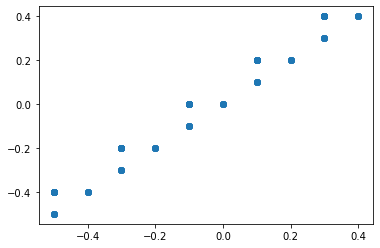

In [22]:
plt.scatter(X_3d[:,0], X_3d[:,1])

In [23]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e2)) * 
    NTK(depth=3, c=2) #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

laplace_kernel = (
    ConstantKernel(constant_value=1e-2, constant_value_bounds=(1e-9, 1e2)) * 
    Matern(length_scale=1, length_scale_bounds=(2e-10, 1e5), nu=1/2) #+
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

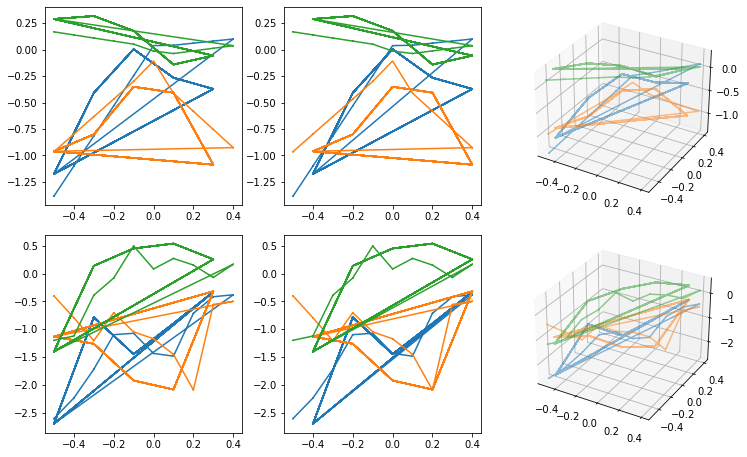

In [24]:
gp_ntk_sample = GPR(kernel=neural_tangent_kernel)
mean_ntk_sample = gp_ntk_sample.predict(X_3d)
samples_ntk = gp_ntk_sample.sample_y(X_3d, 3)

gp_lpk_sample = GPR(kernel=laplace_kernel)
mean_lpk_sample = gp_lpk_sample.predict(X_3d)
samples_lpk = gp_lpk.sample_y(X_3d, 3)
samples_lpk = np.squeeze(samples_lpk)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
ax = ax.ravel()
ax[2].remove()
ax[2] = fig.add_subplot(2,3,3, projection='3d')
ax[5].remove()
ax[5] = fig.add_subplot(2,3,6, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.9)

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(X_3d[:,0], prior)#, linestyle="--", alpha=0.5, label=f"Sampled function #{i + 1}")
    ax[1].plot(X_3d[:,1], prior)#, linestyle="--", alpha=0.5)
    ax[2].plot(X_3d[:,0], X_3d[:,1], prior, alpha=0.5)

for i, prior in enumerate(samples_lpk.T):
    ax[3].plot(X_3d[:,0], prior)#, linestyle="--", alpha=0.5)
    ax[4].plot(X_3d[:,1], prior)#, linestyle="--", alpha=0.5)
    ax[5].plot(X_3d[:,0], X_3d[:,1], prior, alpha=0.5)

# fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

## 1D Function

### Dataset

In [25]:
x_2d = np.linspace(0, 2*np.pi).reshape(-1, 1)
x_2d -= 3
y_2d = np.sin(x_2d)

In [26]:
x_2d_train, x_2d_test, y_2d_train, y_2d_test = train_test_split(
    x_2d, y_2d, test_size=0.5, random_state=624562)

x_2d_train_noisy = x_2d_train
y_2d_train_noisy = np.random.normal(y_2d_train, scale=0.05)

### Gaussian Process Noiseless

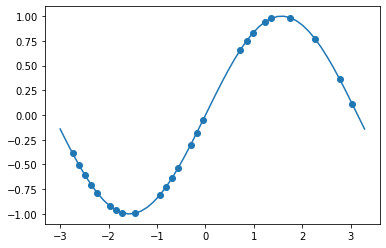

In [27]:
fig, ax = plt.subplots()
ax.plot(x_2d, y_2d)
ax.scatter(x_2d_train, y_2d_train)

In [28]:
np.random.seed(1923048)

neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2, bias=1e-9, bias_bounds='fixed') #+ 
    #WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_ntk_2d = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk_2d.fit(x_2d_train, y_2d_train)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e10)) * 
    Matern(length_scale=0.01, length_scale_bounds='fixed', 
    nu=1/2) #+
    #WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk_2d = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk_2d.fit(x_2d_train, y_2d_train)

print('NTK     : ', gp_ntk_2d.kernel_, '\nLaplace : ', gp_lpk_2d.kernel_)

NTK     :  40**2 * NTK(depth=2, c=2.000, bias=0.000) 
Laplace :  0.718**2 * Matern(length_scale=0.01, nu=0.5)


In [29]:
mean_ntk_2d = gp_ntk_2d.predict(x_2d)
mean_lpk_2d = gp_lpk_2d.predict(x_2d)

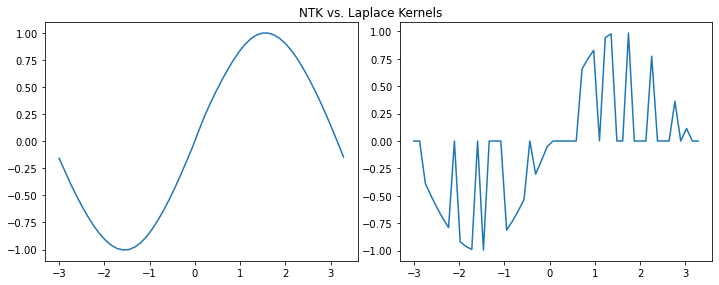

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios' : [1, 1]})
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(x_2d, mean_ntk_2d.ravel())
ax[1].plot(x_2d, mean_lpk_2d.ravel())

_=fig.suptitle("NTK vs. Laplace Kernels")

In [31]:
t = np.linspace(-8, 8, 100)
t = t.reshape(-1,1)
t.shape

(100, 1)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:478: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(y_mean[:, i], y_cov, n_samples).T[:, np.newaxis]


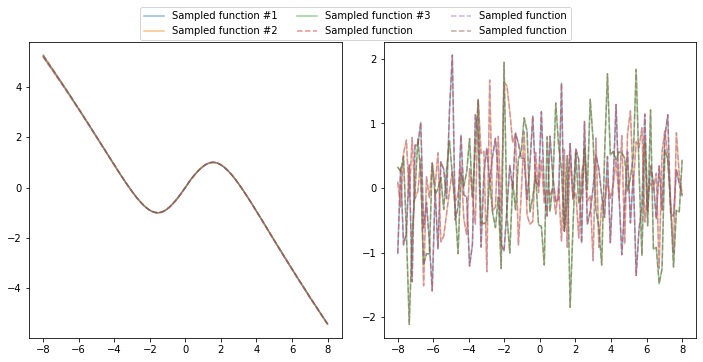

In [32]:
n_samples = 3

mean_ntk_sample = gp_ntk_2d.predict(t)
samples_ntk = gp_ntk_2d.sample_y(t, n_samples, random_state=np.random.randint(1000000000))
samples_ntk = np.squeeze(samples_ntk)

mean_lpk_sample = gp_lpk_2d.predict(t)
samples_lpk = gp_lpk_2d.sample_y(t, n_samples, random_state=np.random.randint(1000000000))
samples_lpk = np.squeeze(samples_lpk)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.9)

# plot(t, samples_ntk.T, typ='sample')

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(t, prior, alpha=0.5, label=f"Sampled function #{i + 1}")

for i, prior in enumerate(samples_lpk.T):
    ax[1].plot(t, prior, alpha=0.5)

ax[0].plot(t, samples_ntk, linestyle="--", alpha=0.5, label="Sampled function")
ax[1].plot(t, samples_lpk, linestyle="--", alpha=0.5)

# ax[0].scatter(x_2d_train, y_2d_train)
# ax[1].scatter(x_2d_train, y_2d_train)

# ax[0].set_ylim(-4, 1.2)
# ax[1].set_ylim(-1.2, 1.2)

fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

In [33]:
# in thesis include plots like this ^ for depth = 1,2,3,4,5 and with lengthscales for c (invert with 1/c)

### Gaussian Process Noisy

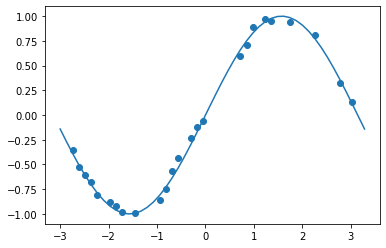

In [34]:
fig, ax = plt.subplots()
ax.plot(x_2d, y_2d)
ax.scatter(x_2d_train_noisy, y_2d_train_noisy)

In [35]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e2)) * 
    NTK(depth=2, c=2, bias=.1, bias_bounds='fixed') + #(1e-9, 1e2)) + 
    WhiteKernel(noise_level=1e-9, noise_level_bounds='fixed')#(1e-9, 1e2))
)
gp_ntk_2d = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk_2d.fit(x_2d_train_noisy, y_2d_train_noisy)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e2)) * 
    Matern(length_scale=2, length_scale_bounds='fixed',#(2e-10, 1e5), 
        nu=1/2) +
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e2))
)
gp_lpk_2d = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk_2d.fit(x_2d_train_noisy, y_2d_train_noisy)

print('NTK     : ', gp_ntk_2d.kernel_)
print('Laplace : ', gp_lpk_2d.kernel_)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


NTK     :  10**2 * NTK(depth=2, c=2.000, bias=0.100) + WhiteKernel(noise_level=1e-09)
Laplace :  0.386**2 * Matern(length_scale=2, nu=0.5) + WhiteKernel(noise_level=1e-09)


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [36]:
# prior covariance matrix 
cov_ntk = gp_ntk_2d.kernel_(x_2d_train_noisy)[15:19, 15:19] 
cov_lpk = gp_lpk_2d.kernel_(x_2d_train_noisy)[15:19, 15:19]

# correlation_from_covariance(cov_ntk), correlation_from_covariance(cov_lpk)
cov_ntk, cov_lpk

(array([[760.83125653,  20.63064506,  69.14348668,  43.02119165],
        [ 20.63064506,  48.38714166, 162.58073816, 101.0918932 ],
        [ 69.14348668, 162.58073816, 551.90133226, 342.267195  ],
        [ 43.02119165, 101.0918932 , 342.267195  , 212.40359849]]),
 array([[0.14891789, 0.02637228, 0.01145962, 0.01795069],
        [0.02637228, 0.14891789, 0.06470971, 0.10136322],
        [0.01145962, 0.06470971, 0.14891789, 0.09506835],
        [0.01795069, 0.10136322, 0.09506835, 0.14891789]]))

In [37]:
mean_ntk_2d, std_ntk = gp_ntk_2d.predict(x_2d, return_std=True)
mean_lpk_2d, std_lpk = gp_lpk_2d.predict(x_2d, return_std=True)

In [38]:
std_ntk, std_lpk

(array([0.00109243, 0.00085161, 0.00065731, 0.00051693, 0.00041769,
        0.0003894 , 0.00038883, 0.00040384, 0.00043082, 0.00045306,
        0.00047297, 0.000499  , 0.00052563, 0.00055316, 0.00056899,
        0.00056912, 0.00054788, 0.00052158, 0.00052807, 0.00060097,
        0.00070077, 0.00073012, 0.00084229, 0.00098104, 0.00924305,
        0.00602113, 0.00386704, 0.0023531 , 0.00135887, 0.00078595,
        0.00054687, 0.00050399, 0.00051392, 0.00052505, 0.00053558,
        0.00055059, 0.00057116, 0.00059535, 0.0006133 , 0.00062665,
        0.00062814, 0.00062099, 0.00059784, 0.00057592, 0.00056948,
        0.00059786, 0.0006749 , 0.00080825, 0.0009952 , 0.00122626]),
 array([0.18354208, 0.13387595, 0.00100097, 0.00100095, 0.00100095,
        0.00100095, 0.00100096, 0.09764825, 0.00100096, 0.00100095,
        0.00100096, 0.09764825, 0.00100098, 0.11943079, 0.13781147,
        0.11943079, 0.00100097, 0.00100095, 0.00100095, 0.00100096,
        0.09764825, 0.00100096, 0.00100095, 0.

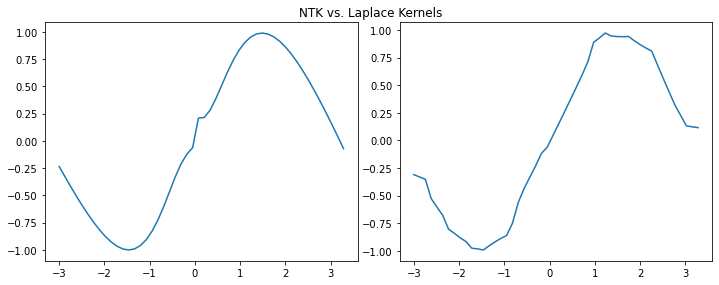

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios' : [1, 1]})
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(x_2d, mean_ntk_2d.ravel())
ax[1].plot(x_2d, mean_lpk_2d.ravel())

_=fig.suptitle("NTK vs. Laplace Kernels")

### Sample Paths

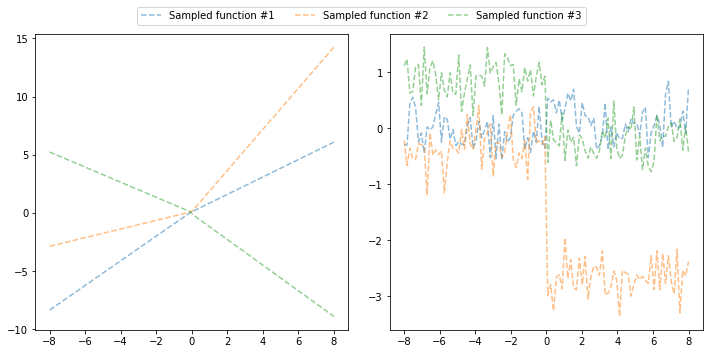

In [40]:
T = normalize(t)

n_samples = 3

neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2) #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

gp_ntk_sample = GPR(kernel=neural_tangent_kernel)
mean_ntk_sample = gp_ntk_sample.predict(t.reshape(-1,1))
samples_ntk = gp_ntk_sample.sample_y(t.reshape(-1,1), n_samples, random_state=np.random.randint(1000000000))
samples_ntk = np.squeeze(samples_ntk)

gp_lpk_sample = GPR(kernel=laplace_kernel)
mean_lpk_sample = gp_lpk_sample.predict(T)
samples_lpk = gp_lpk_sample.sample_y(np.stack((T,T), axis=1).squeeze(), n_samples, random_state=np.random.randint(1000000000))
samples_lpk = np.squeeze(samples_lpk)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.9)

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(t, prior, linestyle="--", alpha=0.5, label=f"Sampled function #{i + 1}")

for i, prior in enumerate(samples_lpk.T):
    ax[1].plot(t, prior, linestyle="--", alpha=0.5)

# ax[0].plot(t, samples_ntk, linestyle="--", alpha=0.5, label="Sampled function")
# ax[1].plot(t, samples_lpk, linestyle="--", alpha=0.5)

fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:478: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(y_mean[:, i], y_cov, n_samples).T[:, np.newaxis]


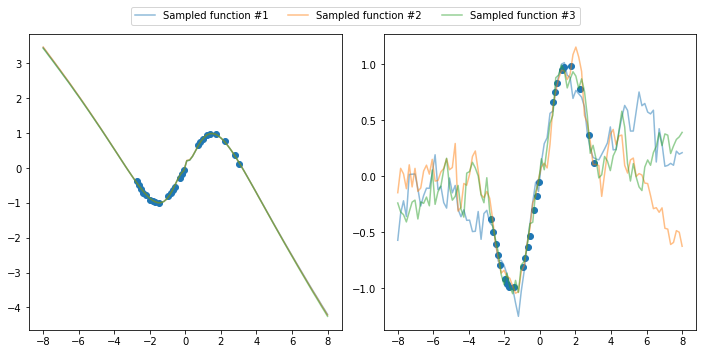

In [41]:
n_samples = 3

mean_ntk_sample = gp_ntk_2d.predict(t)
samples_ntk = gp_ntk_2d.sample_y(t, n_samples, random_state=np.random.randint(1000000000))
samples_ntk = np.squeeze(samples_ntk)

mean_lpk_sample = gp_lpk_2d.predict(t)
samples_lpk = gp_lpk_2d.sample_y(t, n_samples, random_state=np.random.randint(1000000000))
samples_lpk = np.squeeze(samples_lpk)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.9)

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(t, prior, alpha=0.5, label=f"Sampled function #{i + 1}")

for i, prior in enumerate(samples_lpk.T):
    ax[1].plot(t, prior, alpha=0.5)

# ax[0].plot(t, samples_ntk, linestyle="--", alpha=0.5, label="Sampled function")
# ax[1].plot(t, samples_lpk, linestyle="--", alpha=0.5)

ax[0].scatter(x_2d_train, y_2d_train)
ax[1].scatter(x_2d_train, y_2d_train)

# ax[0].set_ylim(-4, 1.2)
# ax[1].set_ylim(-1.2, 1.2)

fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

## 1. $-\sum^6_{k=1} k\sin((k+1)x + k)$

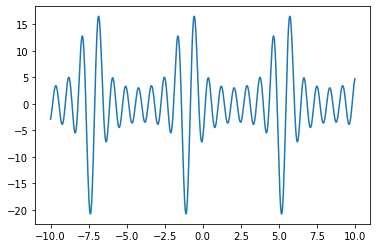

In [42]:
x = np.linspace(-10, 10, 1000).reshape(-1,1)
y = sum([k * np.sin((k+1)*x + k) for k in range(1, 7)])
plt.plot(x,y)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=624562)

x_train_noisy = np.random.normal(x_train, scale=0.15)
y_train_noisy = np.random.normal(y_train, scale=0.15)

In [43]:
np.random.seed(1923048)

neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2, bias=0.5, bias_bounds=(1e-5, 1e5)) #+ 
    #WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

gp_ntk_2d = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk_2d.fit(x_train, y_train)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e10)) * 
    Matern(length_scale=0.01, length_scale_bounds=(2e-10, 1e5), 
    nu=1/2) #+
    #WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk_2d = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk_2d.fit(x_train, y_train)

print('Neural  : ', gp_ntk_2d.kernel_, '\nLaplace : ', gp_lpk_2d.kernel_)

mean_ntk = gp_ntk_2d.predict(x)
mean_lpk = gp_lpk_2d.predict(x)

Neural  :  2.79**2 * NTK(depth=2, c=2.000, bias=0.008) 
Laplace :  6.38**2 * Matern(length_scale=1.31, nu=0.5)


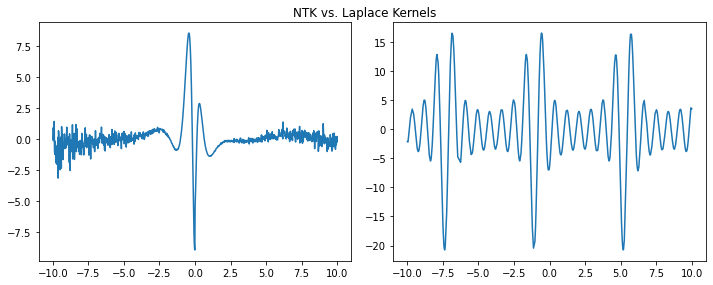

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios' : [1, 1]})
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(x, mean_ntk.ravel())
ax[1].plot(x, mean_lpk.ravel())

_=fig.suptitle("NTK vs. Laplace Kernels")